In [3]:
from eazy.photoz import template_lsq
import astropy.units as u
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
from BDFit import StarFit
from astropy.table import Table
import fnmatch


In [4]:
s = StarFit()

Compiled sonora_bobcat photometry not found.
No sonora_bobcat models found. Running setup_libraries.
sonora_bobcat files not found. Downloading from Zenodo.


Downloaded: attachment; filename=spectra_m+0.0.tar.gz
sonora_bobcat files not found. Downloading from Zenodo.


KeyboardInterrupt: 

/nvme/scratch/work/tharvey/brown_dwarfs/models/sonora_diamondback/t1700g3160f3_m0.0_co1.0_resample.dat
models//models//sonora_diamondback/t1700g3160f4_m0.0_co1.0_resample.dat'

In [ ]:
def find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr'):#, error_wildcard='FLUXERR_APER_*_loc_depth'):
    # glob-like matching for column names
    flux_columns = fnmatch.filter(table.colnames, flux_wildcard)
    # get the band names from the column names
    flux_split = flux_wildcard.split('*')
    flux_bands = [col.replace(flux_split[0], '').replace(flux_split[1], '') for col in flux_columns]
    return flux_bands

def provide_phot(table, bands=None, flux_wildcard='FLUX_APER_*_aper_corr_Jy', error_wildcard='FLUXERR_APER_*_loc_depth_10pc_Jy', min_percentage_error=0.1, flux_unit=u.Jy, multi_item_columns_slice=None):
    
    if bands is None:
        bands = find_bands(table)

    flux_columns = [flux_wildcard.replace('*', band) for band in bands]
    error_columns = [error_wildcard.replace('*', band) for band in bands]

    assert all([col in table.colnames for col in flux_columns]), f'Flux columns {flux_columns} not found in table'
    assert all([col in table.colnames for col in error_columns]), f'Error columns {error_columns} not found in table'

    if multi_item_columns_slice is not None:
        raise NotImplementedError('Do this I guess.')

    fluxes = structured_to_unstructured(table[flux_columns].as_array()) * flux_unit
    errors = structured_to_unstructured(table[error_columns].as_array()) * flux_unit

    mask = ((errors / fluxes) < min_percentage_error) & (fluxes > 0)
    errors[mask] = fluxes[mask] * min_percentage_error

    return fluxes, errors

In [ ]:
catalog = '/raid/scratch/work/jarcidia/GALFIND_WORK/Catalogues/v11/ACS_WFC+NIRCam/COSMOS-Web-0A/(0.32)as/COSMOS-Web-0A_MASTER_Sel-F444W_v11.fits'
table = Table.read(catalog)
bands = find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr_Jy')

s.fit_catalog(provide_phot, photometry_function_kwargs={'table': table}, bands=bands)

/nvme/scratch/work/tharvey/brown_dwarfs/StarFit.py:755: RuntimeWarning: invalid value encountered in divide
  for i in range(self.NSTAR):


/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
<__array_function__ internals>:200: RuntimeWarning: All-NaN axis encountered


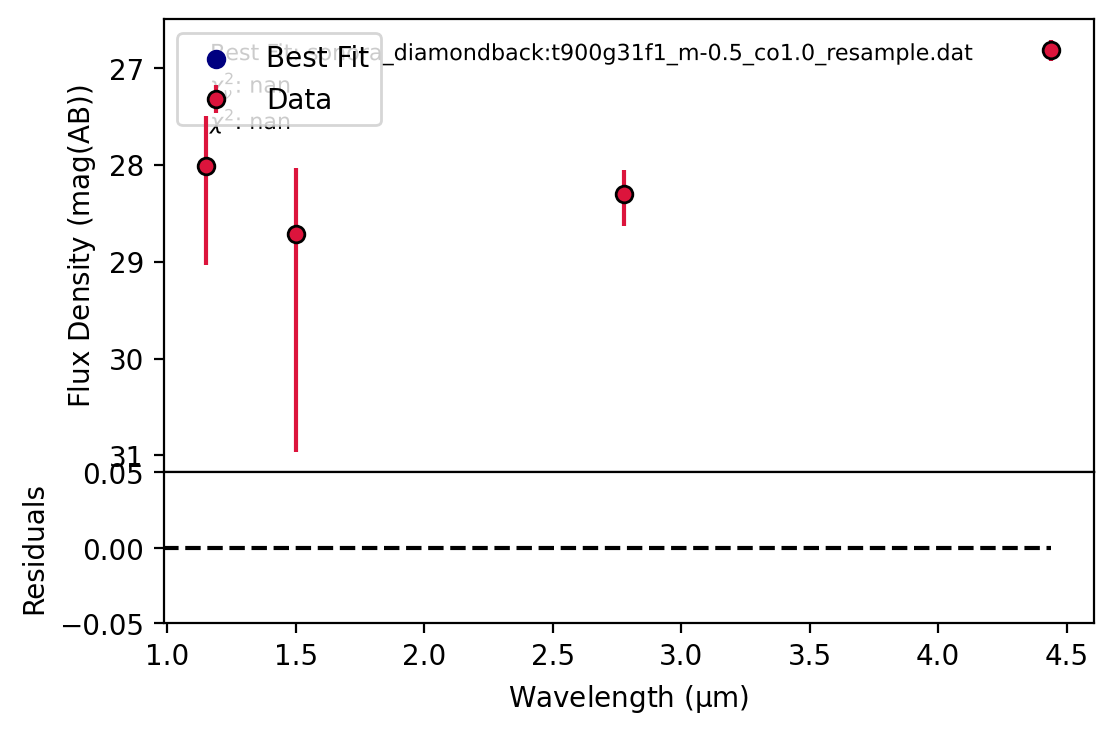

In [ ]:
fig, ax = s.plot_fit(45693, flux_unit=u.ABmag);


In [ ]:
print(s.idx_ranges)

{'sonora_diamondback': (0, 1440)}
